# DTSA-5510 Final Project: Unsupervised Learning on E-Commerce Description Data


**Genesis Zhong**

**August 7th, 2023**

https://github.com/genesischung/5510_final_project

## Introduction

Initially it was difficult to find a data set appropriate for this final project, as I was not sure how to evaluate model performance with unlabeled data. A project without evaluation seems rather incomplete. After completing this course, I have some ideas of what unsupervised models are capable of. However, it makes more sense to me to use supervised models with labeled data.

As I was browsing through the datasets hosted on kaggle, I found [BigBasket Entire Product List](https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints), which is a collection of product listings for BigBasket, an online grocery store in India. The data set contains a wide variety of products, each with a category, a sub-category, a type (or a sub-sub-category), and a description.

E-Commerce has been growing rapidly worldwide and has transformed the way people shop. However, it may sometimes be difficult to find what you are looking for, given the large quantities of products available online. Product categorization is a must for any E-Commerce platform to provide satisfatory customer experience. Everything considered, the BigBasket data set will be great to explore.

## Problem Statement

Given the description of products, will we be able to correctly label the products using unsupervised learning models? In this project, we will attempt to answer that question, and compare the results with a supervised model. In addition, what else are we able to do with unsupervised learning models?

## EDA and Data Cleansing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import re
import nltk

nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import linear_kernel

In [2]:
df = pd.read_csv("data/BigBasket Products.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         27555 non-null  int64  
 1   product       27554 non-null  object 
 2   category      27555 non-null  object 
 3   sub_category  27555 non-null  object 
 4   brand         27554 non-null  object 
 5   sale_price    27555 non-null  float64
 6   market_price  27555 non-null  float64
 7   type          27555 non-null  object 
 8   rating        18929 non-null  float64
 9   description   27440 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 2.1+ MB


After importing the data set, we first take a look at the name of the columns and the number of rows in the data set. Then we drop `index` and `rating`, which we won't be using in this project.

In [4]:
df.drop(["index", "rating"], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27555 entries, 0 to 27554
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product       27554 non-null  object 
 1   category      27555 non-null  object 
 2   sub_category  27555 non-null  object 
 3   brand         27554 non-null  object 
 4   sale_price    27555 non-null  float64
 5   market_price  27555 non-null  float64
 6   type          27555 non-null  object 
 7   description   27440 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.7+ MB


In [6]:
df.sample(5)

,product,category,sub_category,brand,sale_price,market_price,type,description
7811,Argan Oil Handmade Soap,Beauty & Hygiene,Bath & Hand Wash,Nyassa,365.00,365.0,Bathing Bars & Soaps,"Captivate your senses with the rich, sweet and..."
1922,Sanitary Pads - Secure Cottony Soft 20Pads + S...,Beauty & Hygiene,Feminine Hygiene,STAYFREE,102.37,122.0,Sanitary Napkins,Cottony soft cover napkin with wings to protec...
16320,Millet Diet Muesli,Gourmet & World Food,Cereals & Breakfast,Millet Mantra,161.00,230.0,Muesli & Rice Cakes,Millet Diet Muesli is millet-based muesli with...
27062,Phenyle - Cool Cyan,Cleaning & Household,All Purpose Cleaners,Germisol,60.00,60.0,Floor & Other Cleaners,Used to keep the floors of the house clean thi...
22450,Natural Spray - Classic EDT,Beauty & Hygiene,Fragrances & Deos,ARAMIS,2250.00,2250.0,Women's Deodorants,"For the man who is elegant, sophisticated and ..."


Since there are some 555 - 440 = 115 rows with no `description`, we drop these rows. We also drop the row with no `product` and `brand`.

In [7]:
df.dropna(subset=['product', 'brand', 'description'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27439 entries, 0 to 27554
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product       27439 non-null  object 
 1   category      27439 non-null  object 
 2   sub_category  27439 non-null  object 
 3   brand         27439 non-null  object 
 4   sale_price    27439 non-null  float64
 5   market_price  27439 non-null  float64
 6   type          27439 non-null  object 
 7   description   27439 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.9+ MB


In [8]:
df['description'].unique().shape

(21943,)

In [9]:
df[df.duplicated()].tail(5)

,product,category,sub_category,brand,sale_price,market_price,type,description
27189,Pantry/Cookie/Snacks Glass Jar With Blue Lid,"Kitchen, Garden & Pets",Crockery & Cutlery,Yera,229.0,280.0,Glassware,PantryMate Storage Jars with Lids are a chic s...
27371,"Adult Diapers Economy, Medium",Beauty & Hygiene,Health & Medicine,Friends,425.0,425.0,Adult Diapers,Friends Economy Adult Diaper comes with an ant...
27375,Taft Ultimate Wax,Beauty & Hygiene,Hair Care,Schwarzkopf,425.0,425.0,Hair Care & Styling,Ultimate strongest taffeta-stop for 100% fixat...
27412,Whisky Tumblers/Glass,"Kitchen, Garden & Pets",Crockery & Cutlery,Yera,319.0,385.0,Glassware,Yera is the pioneer in India’s glass Industry ...
27549,Papad - Garlic Disco,Snacks & Branded Foods,Ready To Cook & Eat,Atish,61.0,61.0,"Papads, Ready To Fry",Papads are prepared from urad dal flour and sp...


In [10]:
df[df['product'] == 'Papad - Garlic Disco']

,product,category,sub_category,brand,sale_price,market_price,type,description
8369,Papad - Garlic Disco,Snacks & Branded Foods,Ready To Cook & Eat,Atish,61.0,61.0,"Papads, Ready To Fry",Papads are prepared from urad dal flour and sp...
27549,Papad - Garlic Disco,Snacks & Branded Foods,Ready To Cook & Eat,Atish,61.0,61.0,"Papads, Ready To Fry",Papads are prepared from urad dal flour and sp...


We check if there is any duplicate description in the data set. And in fact there are quite a few. So we drop these rows with duplicated descriptions. 

In [11]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27057 entries, 0 to 27554
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product       27057 non-null  object 
 1   category      27057 non-null  object 
 2   sub_category  27057 non-null  object 
 3   brand         27057 non-null  object 
 4   sale_price    27057 non-null  float64
 5   market_price  27057 non-null  float64
 6   type          27057 non-null  object 
 7   description   27057 non-null  object 
dtypes: float64(2), object(6)
memory usage: 1.9+ MB


In [12]:
df.category.value_counts()

Beauty & Hygiene            7653
Gourmet & World Food        4633
Kitchen, Garden & Pets      3433
Snacks & Branded Foods      2809
Foodgrains, Oil & Masala    2652
Cleaning & Household        2639
Beverages                    880
Bakery, Cakes & Dairy        850
Baby Care                    608
Fruits & Vegetables          556
Eggs, Meat & Fish            344
Name: category, dtype: int64

In [13]:
df.category.unique()

array(['Beauty & Hygiene', 'Kitchen, Garden & Pets',
       'Cleaning & Household', 'Gourmet & World Food',
       'Foodgrains, Oil & Masala', 'Snacks & Branded Foods', 'Beverages',
       'Bakery, Cakes & Dairy', 'Baby Care', 'Fruits & Vegetables',
       'Eggs, Meat & Fish'], dtype=object)

Since there are 11 categories in the data set, it made permutation extremely resource intensive when trying to fit the right labels. So we drop some categories and reduce the number of categories to 6. 

In [14]:
# 11 is too much to permuate labels
# to speed up computation, we use a partial data set
# and reduce # category to 6
for cat in ['Snacks & Branded Foods', 'Beverages', 
            'Bakery, Cakes & Dairy', 'Foodgrains, Oil & Masala','Eggs, Meat & Fish']:   
    indexDrop = df[df['category'] == cat].index
    df.drop(indexDrop, inplace=True)

In [15]:
df.category.unique().shape

(6,)

In [16]:
df.sub_category.value_counts()

Skin Care                      2217
Health & Medicine              1122
Storage & Accessories           997
Fragrances & Deos               990
Bath & Hand Wash                970
Hair Care                       949
Snacks, Dry Fruits, Nuts        828
Men's Grooming                  795
Crockery & Cutlery              772
Drinks & Beverages              730
Cooking & Baking Needs          687
Sauces, Spreads & Dips          648
Chocolates & Biscuits           605
All Purpose Cleaners            472
Stationery                      392
Bins & Bathroom Ware            386
Cookware & Non Stick            353
Pet Food & Accessories          353
Steel Utensils                  350
Mops, Brushes & Scrubs          348
Kitchen Accessories             328
Feminine Hygiene                285
Fresheners & Repellents         275
Oral Care                       270
Detergents & Dishwash           261
Dairy & Cheese                  252
Pooja Needs                     252
Pasta, Soup & Noodles       

In [17]:
df[df.category=='Cleaning & Household'].sub_category.value_counts()

All Purpose Cleaners        472
Stationery                  392
Bins & Bathroom Ware        386
Mops, Brushes & Scrubs      348
Fresheners & Repellents     275
Detergents & Dishwash       261
Pooja Needs                 252
Disposables, Garbage Bag    163
Party & Festive Needs        48
Car & Shoe Care              42
Name: sub_category, dtype: int64

In the bar plot below, it shows the number of products in each category. It's quite clear that `Beauty & Hygiene` has a large number of products, whereas `Baby Care` and `Fruits & Vegetables` has much less products. This reflects the real life scenario where the number of products in each category is not always balanced.

[Text(0.5, 1.0, 'Number of Products in Each Category')]

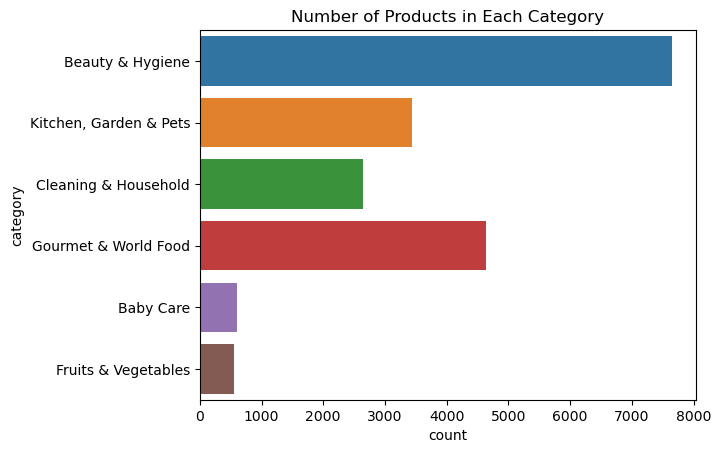

In [18]:
sns.countplot(y='category', data=df).set(title="Number of Products in Each Category")

My strategy for data cleansing is:
- Remove terms with only numbers, as these carry no meaningful difference
- Convert everything to lower case
- Perform Lemmatization
- Use stop words to filter some common terms

So below I write a function, which can be applied to perform the cleansing. Stop words will be filtered in the vectorizer.

In [19]:
lemma = WordNetLemmatizer()

def dataCleansing(text):
    lemmaText = ""
    for word in text.split():
        # remove numbers
        if re.match('^[0-9]+$', word):
            continue
        # convert to lower case
        word = word.lower()
        # lemmatize
        lem = lemma.lemmatize(word)
        lemmaText += lem
        lemmaText += " "
    lemmaText = lemmaText.strip()
    return lemmaText

In [20]:
df_clean = pd.DataFrame({'description': df['description'].apply(lambda x: dataCleansing(x)),
                        'category': df['category'],
                        'sub_category': df['sub_category']})

Below is a distribution plot of the description length. As shown in the plot, the majority of descriptions are over 50 words  in length, so there is a good chance we can capture useful information about the products from them.

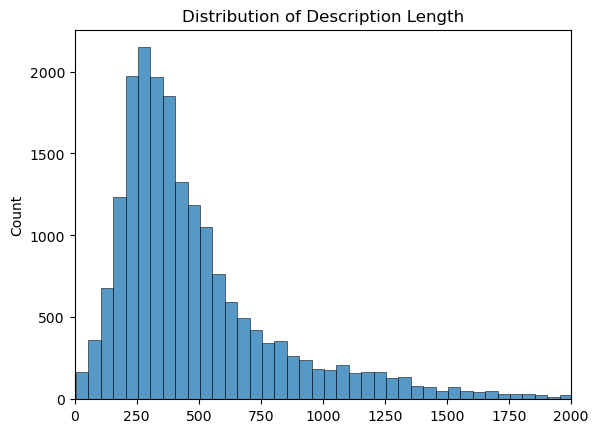

In [21]:
def plotLength():
    """
    plot the length of description length
    """
    lengths = [len(text) for text in df_clean['description']]
    sns.histplot(x=lengths, binwidth=50).set(title="Distribution of Description Length", xlim=[0, 2000])

plotLength()

My next step is to plot the most frequent words and ngrams in the data set. And I noticed that terms such as `bigbasket`, `https`, and `com` appear on top of each of them, presumly because many product descriptions mention checking out their website. So below I made a custom stop word lists to include these terms

In [22]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend("www bigbasket https http com blog".split())

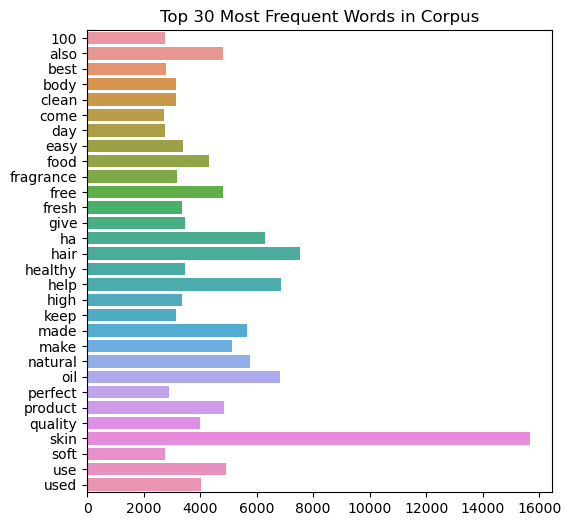

In [23]:
def plot_top_words(n=20):
    vec = CountVectorizer(stop_words=stpwrd,
                         lowercase=True,
                         max_features=n)
    X = vec.fit_transform(df_clean['description'])
    plt.figure(figsize=(6, n/5))
    sns.barplot(x=np.sum(X.toarray(), axis=0),
                y=vec.get_feature_names_out(),
                orient='h').set(title="Top {} Most Frequent Words in Corpus".format(n))

plot_top_words(30)

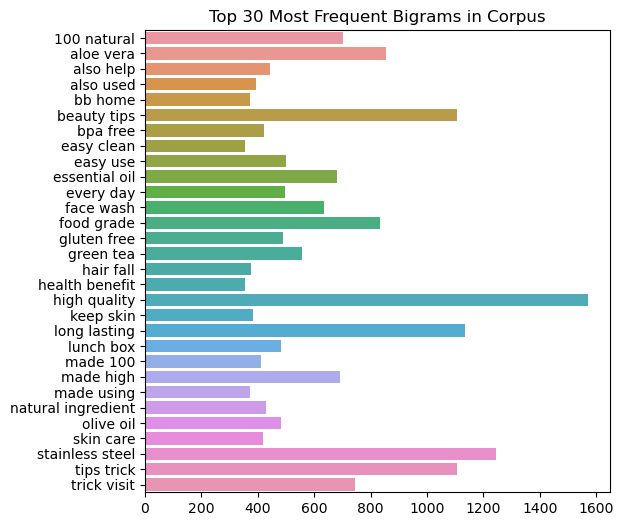

In [24]:
def plot_top_bigrams(n=20):
    vec = CountVectorizer(stop_words=stpwrd,
                         lowercase=True,
                         max_features=n,
                         ngram_range=(2,2))
    X = vec.fit_transform(df_clean['description'])
    plt.figure(figsize=(6, n/5))
    sns.barplot(x=np.sum(X.toarray(), axis=0),
                y=vec.get_feature_names_out(),
                orient='h').set(title="Top {} Most Frequent Bigrams in Corpus".format(n))

plot_top_bigrams(30)

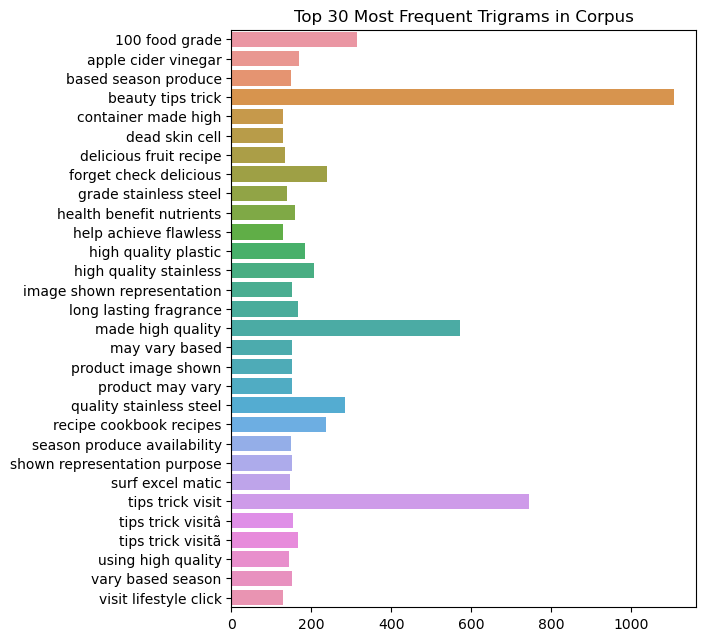

In [25]:
def plot_top_trigrams(n=20):
    vec = CountVectorizer(stop_words=stpwrd,
                         lowercase=True,
                         max_features=n,
                         ngram_range=(3,3))
    X = vec.fit_transform(df_clean['description'])
    plt.figure(figsize=(6, n/4))
    sns.barplot(x=np.sum(X.toarray(), axis=0),
                y=vec.get_feature_names_out(),
                orient='h').set(title="Top {} Most Frequent Trigrams in Corpus".format(n))

plot_top_trigrams(30)

# Modeling

Our plan is to build models as follows:

- Unsupervised:
    - Bag of Words vectorizer + LDA
    - TF-IDF vectorizer + LDA
    - TF-IDF vectorizer + NMF
- Supervised:
    - TF-IDF vectorizer + Random Forest
    
First we will attempt Latent Dirichlet Allocation (LDA) with two different vectorizers, Bow and TF-IDF for feature extraction. LDA is an unsupervised learning algorithm for finding latent groupings in the data set, and is one of the more popular algorithm in Natural Language Processing. we will also do the NMF method we learned in week 4. Lastly, we will build a Random Forest model for comparison.

Since we are also doing a supervised model, the data set is split into a training set and a test set. The training set contains 80% of the data set. Each model will be evaluated on both the training set and the set set. 

For evaluation, we will be mostly using accuracy and weighted-averaged F1 Score. We will also use the precision and recall within each group, as well as confusion matrix for more insights.

In [26]:
y = df_clean.category
X = df_clean.description

# split data set into training set (80%) and test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [27]:
def label_permute_compare(yt,yp,n=6):
    """
    Modified from week 2 homework
    """
    labels = list(yt.unique())
    label_acc = dict()
    
    # go through all permutation of the labels
    # and store the accuracy in dict
    for perm in itertools.permutations(range(n)):
        label_map = dict(zip(labels, perm))
        yhat = yt.apply(lambda x:label_map[x])
        label_acc[perm] = accuracy_score(yhat, yp)
        
    # get the key with best accuracy
    best_perm = max(label_acc, key=label_acc.get)
    best_map = dict(zip(best_perm, labels))
    yp_labeled = pd.DataFrame({'yp':yp})['yp'].apply(lambda x:best_map[x])
    
    # print evaluation feedback
    print(classification_report(yt, yp_labeled))
    print(confusion_matrix(yt, yp_labeled))
    
    return best_perm, label_acc[best_perm], labels

### Bag of words vectorizer + LDA


In [28]:
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.9,
                             min_df=0.01,
                             stop_words=stpwrd,             
                             lowercase=True,                   
                             max_features=5000)
    
df_vec = vectorizer.fit_transform(X_train)
    
lda = LatentDirichletAllocation(n_components=6,
                                learning_method='online',
                                random_state=2023,       
                                n_jobs = -1)
lda_output = lda.fit_transform(df_vec)

yp_train = lda_output.argmax(axis=1)

In [29]:
# training set evaluation
print("BoW + LDA Training Set")
label_permute_compare(y_train, yp_train, n=6)

BoW + LDA Training Set
                        precision    recall  f1-score   support

             Baby Care       0.02      0.09      0.03       485
      Beauty & Hygiene       0.92      0.40      0.55      6135
  Cleaning & Household       0.43      0.40      0.41      2143
   Fruits & Vegetables       0.06      0.21      0.09       433
  Gourmet & World Food       0.73      0.65      0.69      3687
Kitchen, Garden & Pets       0.64      0.85      0.73      2734

              accuracy                           0.52     15617
             macro avg       0.46      0.43      0.42     15617
          weighted avg       0.71      0.52      0.57     15617

[[  45  112  268    5   18   37]
 [1386 2436  765  965  469  114]
 [  55   49  850  212   46  931]
 [  24    2    0   90  317    0]
 [ 808   30   32  186 2397  234]
 [ 220   23   78   42   47 2324]]


((0, 4, 2, 5, 3, 1),
 0.5213549337260678,
 ['Baby Care',
  'Fruits & Vegetables',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Gourmet & World Food',
  'Kitchen, Garden & Pets'])

In [30]:
X_test_vec = vectorizer.transform(X_test)
lda_out_test = lda.transform(X_test_vec)
yp_test = lda_out_test.argmax(axis=1)

# test set evaluation
print("BoW + LDA Test Set")
label_permute_compare(y_test, yp_test, n=6)

BoW + LDA Test Set
                        precision    recall  f1-score   support

             Baby Care       0.02      0.12      0.04       123
      Beauty & Hygiene       0.90      0.39      0.55      1518
  Cleaning & Household       0.42      0.38      0.40       496
   Fruits & Vegetables       0.07      0.19      0.10       123
  Gourmet & World Food       0.75      0.66      0.70       946
Kitchen, Garden & Pets       0.64      0.86      0.74       699

              accuracy                           0.53      3905
             macro avg       0.47      0.44      0.42      3905
          weighted avg       0.70      0.53      0.57      3905

[[ 15  35  67   0   2   4]
 [377 599 172 225 102  43]
 [ 16  17 190  40   5 228]
 [  7   0   0  23  93   0]
 [197   8   8  45 627  61]
 [ 53   6  20   9   9 602]]


((1, 3, 2, 5, 0, 4),
 0.5265044814340589,
 ['Kitchen, Garden & Pets',
  'Gourmet & World Food',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Baby Care',
  'Fruits & Vegetables'])

### TF-IDF + LDA

In [31]:
tfidf = TfidfVectorizer(max_df = 0.95, max_features = 5000, lowercase = True, stop_words = stpwrd)
tfidf_train = tfidf.fit_transform(X_train)
lda_tfidf = LatentDirichletAllocation(n_components=6,
                                learning_method='online',
                                random_state=2023,       
                                n_jobs = -1)
lda_out_tfidf = lda_tfidf.fit_transform(tfidf_train)
yp_train_tfidf = lda_out_tfidf.argmax(axis=1)


In [32]:
# training set evaluation
print("TF-IDF + LDA Training Set")
label_permute_compare(y_train, yp_train_tfidf, n=6)

TF-IDF + LDA Training Set
                        precision    recall  f1-score   support

             Baby Care       0.21      0.42      0.28       485
      Beauty & Hygiene       0.83      0.64      0.72      6135
  Cleaning & Household       0.16      0.13      0.14      2143
   Fruits & Vegetables       0.51      0.79      0.62       433
  Gourmet & World Food       0.89      0.92      0.90      3687
Kitchen, Garden & Pets       0.59      0.80      0.68      2734

              accuracy                           0.66     15617
             macro avg       0.53      0.62      0.56     15617
          weighted avg       0.68      0.66      0.66     15617

[[ 205  170    9    0   35   66]
 [ 665 3904 1271    5  145  145]
 [  10  477  272   92   13 1279]
 [   0    3    1  343   86    0]
 [  45   84   43   93 3397   25]
 [  33   66  144  136  156 2199]]


((3, 0, 1, 4, 5, 2),
 0.6608183389895627,
 ['Baby Care',
  'Fruits & Vegetables',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Gourmet & World Food',
  'Kitchen, Garden & Pets'])

In [33]:
tfidf_test = tfidf.transform(X_test)
lda_tfidf_test = lda_tfidf.transform(tfidf_test)
yp_test_tfidf = lda_tfidf_test.argmax(axis=1)

print("TF-IDF + LDA Test Set")
label_permute_compare(y_test, yp_test_tfidf, n=6)

TF-IDF + LDA Test Set
                        precision    recall  f1-score   support

             Baby Care       0.23      0.45      0.31       123
      Beauty & Hygiene       0.84      0.65      0.74      1518
  Cleaning & Household       0.14      0.11      0.12       496
   Fruits & Vegetables       0.51      0.68      0.58       123
  Gourmet & World Food       0.88      0.94      0.91       946
Kitchen, Garden & Pets       0.60      0.80      0.68       699

              accuracy                           0.67      3905
             macro avg       0.53      0.61      0.56      3905
          weighted avg       0.69      0.67      0.67      3905

[[ 55  43   0   0   9  16]
 [169 991 278   3  29  48]
 [  0 104  54  20   5 313]
 [  0   1   1  84  37   0]
 [  5  19  14  20 887   1]
 [  8  19  37  38  36 561]]


((2, 5, 1, 4, 3, 0),
 0.6740076824583867,
 ['Kitchen, Garden & Pets',
  'Gourmet & World Food',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Baby Care',
  'Fruits & Vegetables'])

### TF-IDF + NMF

In [34]:
# NMF
def predict_from_W(W):
    """
    make predictions from NMF
    """
    sorted_W = np.argsort(W)
    n, n_cat = sorted_W.shape
    prediction = [[sorted_W[i][n_cat-1]] for i in range(n)]
    yp = np.empty(n, dtype=np.int64)
    for i in range(n):
        yp[i] = prediction[i][0]
    return yp


tfidf = TfidfVectorizer(max_df = 0.95, max_features = 5000, lowercase = True, stop_words = stpwrd)
tfidf_train = tfidf.fit_transform(X_train)

nmf = NMF(n_components=6, random_state=2023, init='nndsvdar', solver='mu', 
               beta_loss='kullback-leibler')
nmf.fit(tfidf_train)
yp_nmf = predict_from_W(nmf.transform(tfidf_train))

print("TF-IDF + NMF Training Set")
label_permute_compare(y_train, yp_nmf, n=6)

TF-IDF + NMF Training Set
                        precision    recall  f1-score   support

             Baby Care       0.03      0.07      0.04       485
      Beauty & Hygiene       0.90      0.44      0.59      6135
  Cleaning & Household       0.43      0.49      0.46      2143
   Fruits & Vegetables       0.00      0.00      0.00       433
  Gourmet & World Food       0.82      0.91      0.86      3687
Kitchen, Garden & Pets       0.72      0.81      0.77      2734

              accuracy                           0.60     15617
             macro avg       0.48      0.46      0.45     15617
          weighted avg       0.73      0.60      0.64     15617

[[  34   77  319    3   29   23]
 [1050 2719  885 1402   66   13]
 [  48   32 1058  228    7  770]
 [   8    1    0    1  423    0]
 [  26  151   36   85 3343   46]
 [  40   53  155   62  198 2226]]


((2, 3, 5, 0, 4, 1),
 0.6006915540756868,
 ['Baby Care',
  'Fruits & Vegetables',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Gourmet & World Food',
  'Kitchen, Garden & Pets'])

In [35]:
tfidf_test = tfidf.transform(X_test)
yp_nmf_test = predict_from_W(nmf.transform(tfidf_test))

print("TF-IDF + NMF Test Set")
label_permute_compare(y_test, yp_nmf_test, n=6)

TF-IDF + NMF Test Set
                        precision    recall  f1-score   support

             Baby Care       0.01      0.04      0.02       123
      Beauty & Hygiene       0.88      0.44      0.59      1518
  Cleaning & Household       0.42      0.49      0.45       496
   Fruits & Vegetables       0.00      0.01      0.00       123
  Gourmet & World Food       0.83      0.92      0.88       946
Kitchen, Garden & Pets       0.73      0.81      0.77       699

              accuracy                           0.60      3905
             macro avg       0.48      0.45      0.45      3905
          weighted avg       0.73      0.60      0.64      3905

[[  5  32  77   1   7   1]
 [312 668 206 312  11   9]
 [ 15   7 241  44   0 189]
 [  1   1   0   1 120   0]
 [  7  34   6  19 874   6]
 [ 20  17  40  17  39 566]]


((1, 4, 5, 0, 2, 3),
 0.6030729833546735,
 ['Kitchen, Garden & Pets',
  'Gourmet & World Food',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Baby Care',
  'Fruits & Vegetables'])

### Random Forest Classifier

In [36]:
# Random Forest
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=2023)
rf.fit(tfidf_train, y_train)
yp_rf = rf.predict(tfidf_test)
print("Random Forest Classifier - Test Set")
print(accuracy_score(y_test, yp_rf))
print(classification_report(y_test, yp_rf))
print(confusion_matrix(y_test, yp_rf))

Random Forest Classifier - Test Set
0.9562099871959027
                        precision    recall  f1-score   support

             Baby Care       0.96      0.88      0.92       123
      Beauty & Hygiene       0.96      0.98      0.97      1518
  Cleaning & Household       0.94      0.90      0.92       496
   Fruits & Vegetables       1.00      0.92      0.96       123
  Gourmet & World Food       0.94      0.98      0.96       946
Kitchen, Garden & Pets       0.98      0.94      0.96       699

              accuracy                           0.96      3905
             macro avg       0.96      0.93      0.95      3905
          weighted avg       0.96      0.96      0.96      3905

[[ 108    9    2    0    4    0]
 [   3 1487    7    0   18    3]
 [   0   26  446    0   13   11]
 [   0    0    0  113   10    0]
 [   1   17    2    0  924    2]
 [   0   16   16    0   11  656]]


In [37]:
yp_train_rf = rf.predict(tfidf_train)
print("Random Forest Classifier - Train Set")
print(accuracy_score(y_train, yp_train_rf))
print(classification_report(y_train, yp_train_rf))
print(confusion_matrix(y_train, yp_train_rf))

Random Forest Classifier - Train Set
0.9984632131651405
                        precision    recall  f1-score   support

             Baby Care       1.00      1.00      1.00       485
      Beauty & Hygiene       1.00      1.00      1.00      6135
  Cleaning & Household       1.00      0.99      1.00      2143
   Fruits & Vegetables       1.00      1.00      1.00       433
  Gourmet & World Food       1.00      1.00      1.00      3687
Kitchen, Garden & Pets       0.99      1.00      1.00      2734

              accuracy                           1.00     15617
             macro avg       1.00      1.00      1.00     15617
          weighted avg       1.00      1.00      1.00     15617

[[ 483    2    0    0    0    0]
 [   2 6127    0    0    0    6]
 [   0    0 2132    0    1   10]
 [   0    0    0  433    0    0]
 [   0    0    0    0 3685    2]
 [   0    0    1    0    0 2733]]


### Results

The evaluation results are in the table below:

|       **Model**       | **Accuracy (train)** | **Weighted F1 Score (train)** | **Accuracy (test)** | **Weighted F1 Score (test)** |
|:----------------------:|:--------------------:|:-----------------------------:|:-------------------:|:----------------------------:|
|        BoW + LDA       |         0.52         |              0.57             |         0.53        |             0.57             |
|      TF-IDF + LDA      |         0.66         |              0.66             |         0.67        |             0.67             |
|      TF-IDF + NMF      |         0.60         |              0.64             |         0.60        |             0.64             |
| TF-IDF + Random Forest |         1.00         |              1.00             |         0.96        |             0.96             |

Using TF-IDF for feature extraction is better than BoW, as LDA achieves better accuracy and higher weighted F1 score than BoW.  

NMF did not perform as well as LDA, when using the same features extracted using TF-IDF. Nonetheless, the best performing unsupervised model only achieves an accuracy of 0.66 on the training set, and 0.67 on the test set.

On contrast, the Random Forest model achieves a 1.00 accuracy on the training set (which is somewhat expected) and 0.96 on the test set. So it is indeed possible to accurately categorize the products by the descriptions. It's just that unsupervised models did not perform well for the task here.

To understand why unsupervised models perform not as well, we will take a closer inspection at the results of unsupervised models in the section below.

### Explore Results from LDA

Let's first take a closer look at the best unsupervised results, which is the one using TF-IDF and LDA.

In [38]:
print("TF-IDF + LDA (Best Results) Test Set")
label_permute_compare(y_test, yp_test_tfidf, n=6)

TF-IDF + LDA (Best Results) Test Set
                        precision    recall  f1-score   support

             Baby Care       0.23      0.45      0.31       123
      Beauty & Hygiene       0.84      0.65      0.74      1518
  Cleaning & Household       0.14      0.11      0.12       496
   Fruits & Vegetables       0.51      0.68      0.58       123
  Gourmet & World Food       0.88      0.94      0.91       946
Kitchen, Garden & Pets       0.60      0.80      0.68       699

              accuracy                           0.67      3905
             macro avg       0.53      0.61      0.56      3905
          weighted avg       0.69      0.67      0.67      3905

[[ 55  43   0   0   9  16]
 [169 991 278   3  29  48]
 [  0 104  54  20   5 313]
 [  0   1   1  84  37   0]
 [  5  19  14  20 887   1]
 [  8  19  37  38  36 561]]


((2, 5, 1, 4, 3, 0),
 0.6740076824583867,
 ['Kitchen, Garden & Pets',
  'Gourmet & World Food',
  'Cleaning & Household',
  'Beauty & Hygiene',
  'Baby Care',
  'Fruits & Vegetables'])

If we look at the precision, recall, and f1 scores, it's quite obvious that the scores are quite unbalanced. For example, `Gourmet & World Food` has a precision of 0.88 and f1 score of 0.91, which is quite well. On the other hand, `Cleaning & Household` has a precision of only 0.14 and a f1 score of just 0.12. All in all, the evaluation metrics vary significantly for different categories.

So let's take a look at the confusion matrix. 

`Gourmet & World Food` has 946 products. 887 of these are correctly labeled. 20 are mislabeled as `Fruits & Vegetables`. If we think about it, the difference between `Food` and `Fruits & Vegetables` is quite small. It's not unusual for someone to use similar terms to describe them. After all, they are both "edible product". 

`Cleaning & Household` has 496 products. Only 54 are correctly labeled, whereas 313 are mislabeled as `Kitchen, Garden, & Pets`. Personally, I think `Kitchen, Garden, & Pets` does not contain similar products. I would easily associate `Cleaning & Household` with what we use in the kitchen. Pet products just seem to be a totally different type of products.

So my theory for why unsupervised model performs poorly is that unsupervised models simply discover the hidden groupings in the data set. The labels (categories) we have for this data set are not defined systemically and there is sometimes a lack of uniformity in the categories. So a supervised model is better suited for the task we set to do.

To test our theory, we list some products that LDA failed to correctly label below.


In [39]:
def getComparisonDf():
    """
    concat yp with yt and description
    """
    best_map = dict(zip((2, 5, 1, 4, 3, 0), ['Kitchen, Garden & Pets',
      'Gourmet & World Food',
      'Cleaning & Household',
      'Beauty & Hygiene',
      'Baby Care',
      'Fruits & Vegetables']))
    yp_labeled = pd.DataFrame({'yp':yp_test_tfidf})['yp'].apply(lambda x:best_map[x])
    df_comparison = pd.DataFrame({'yp':yp_labeled,
                                 'yt':np.array(y_test),
                                 'description':np.array(X_test)})
    return df_comparison

Let's first take a look at those that we mistakenly labeled as `Cleaning & Household` when the true label is `Kitchen, Garden & Pets`. It's quite obvious that most if not all of them are products for pets.

In [40]:
df_tfidf_test = getComparisonDf()
with pd.option_context('display.max_colwidth', None):
    display(df_tfidf_test[df_tfidf_test['yt'] == 'Kitchen, Garden & Pets'].query("yp == 'Cleaning & Household'").head())

,yp,yt,description
113,Cleaning & Household,"Kitchen, Garden & Pets","with this grooming clove, completely forget about shedding like an awful nightmare. get rid of hairball before they appear once and for all! our high-quality grooming glove wa designed to be extremely gentle with your pet, bringing only satisfaction and pleasure."
280,Cleaning & Household,"Kitchen, Garden & Pets","pedigree is a complete and balanced food for dogs. prepared with high-quality ingredients, pedigree is rich in protein and nutrition. pedigree pet food provides dog with the sign of good health - healthy skin and coat, strong bone and teeth, digestive health, strong muscle and strong immune system. it also contains the optimal blend of omega and zinc, which are proven to provide a healthier and shinier coat to puppy and adult dogs. pedigree dog food is suited for all dog breed from pugs, beagle to labrador, golden retriever & german shepherd."
311,Cleaning & Household,"Kitchen, Garden & Pets","pedigree is a complete and balanced food for dogs. prepared with high-quality ingredients, suitable for your dog's palette, and also rich in protein and nutrition. pedigree provides dog with the sign of good health - stronger immune system, strong muscles, optimal digestion, strong bone & teeth and healthy skin and coat. pedigree dog food contains 24% crude protein, 10% crude fat, and 5% crude fibre. it also contains the optimal blend of omega and zinc, which are proven to provide a healthier and shinier coat to puppy and adult dogs. pedigree dog food is suited for all puppy breed from pugs, beagle to labrador, golden retriever & german shepherd."
315,Cleaning & Household,"Kitchen, Garden & Pets","share moment of happiness and joy with your dog with pedigree treat. these dog treat are the perfect combination of great tasting real meat and a soft chewy texture that make it a special treat to be share every day. this pedigree adult dog snack offer your best buddy an over-the-top meat experience. made with real meat, these treat actually smell and taste great. just watch a your dog come running in after the first delicious whiff of meat a you open the pack. these tasty dog treat are a deliciously ideal for when you want to see that look of happiness on his sweet face or present a a reward when training your dog. pedigree dog treat are suited for all puppy breed from pugs, beagle to labrador, golden retriever & german shepherd."
844,Cleaning & Household,"Kitchen, Garden & Pets","whiskas adult cat food is the nutrition that your cat need for a healthy and active lifestyle. whiskas cat food is a complete and balanced meal designed to take care of your cat’s daily nutritional requirement and provide it with all the vitamin and mineral needed for a healthy and happy life. this dry cat food help support the cat's vital system by providing it a healthy and shiny coat, healthy eyesight, and energy to be lively and active. in addition, with a texture that appeal to the palate of your feline, whiskas ensures meal time is filling and fun! whiskas cat food is ideal for cat breed from persian cat, british shorthair to siamese cat."


Now if we look at those correctly labeled as `Kitchen, Garden & Pets`, none of them are pet products.

In [41]:
with pd.option_context('display.max_colwidth', None):
    display(df_tfidf_test[df_tfidf_test['yt'] == 'Kitchen, Garden & Pets'].query("yp == yt"))

,yp,yt,description
0,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","now free your environment, and yourself from the unhealthy plastic bottle and get a healthier one-time product for all your needs. copper is one of the metal that ha the ability to kill bacteria and protects from health risk. drinking water from copper bottles/jugs creates a natural purification process. water stored in a copper jug/ bottle, preferably overnight or at least for four hours, acquires a certain quality from the copper. drinking water in copper bottle may aid in weight loss and help boost the immune system."
1,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","famous for high quality and performance, we pour all our experience into creating beautifully designed, practical product like our trendsetting range. strikingly elegant in every table setting, every piece help transform simple gathering into stylish occasions. can be safely used in the microwave, oven, fridge, freezer and dishwasher. unlike plastic will not leech chemical into your food even over repeated usage. the non-porous glass will not absorb stain or odours. you can serve you're guest with yummy salads, pudding and vegetable by preparing them in this clear transparent glass bowl.benefits: stain resistant3 layered glassfreezer safechip resistantpatterns won’t wash, wear or scratch off"
8,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","now free your environment, and yourself from the unhealthy plastic bottle and get a healthier one-time product for all your needs. these high-grade stainless steel bottle are here to enhance your dining and travelling experience, saving you from the negative effect of plastic. the single-walled steel bottle are perfect add-on to your kitchen collection if you are looking for light-weighed, durable, classy looking product. the bottle come with sipper & wide mouth steel cap, catering to double usage. be it going to the gym, or sending it with the kid to school, the colourful sipper can always make it a very convenient, handy and more importantly a style-statement product. you can take it to the office or just keep on the dinner table. open the wide mouth lid and use at ease. the bottle come with the major usp of inter-changeable lid facility. now you can make the same steel cap bottle a a sipper bottle by just interchanging the lids. hence, get of two-in-one featured bottle of same model and capacity and get the best of both, with a variety of colours!"
19,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","pantrymate storage jar with lid are a chic series of storage jars. show off these new addition in your kitchen shelf and on the dining table, a they would fit well and add a sophisticated character to your display with their unique designs. wash 'em, dry 'em in the sun and fill 'em up to the brim with raashan, anaaj, pickles, jams, snacks, spice or lentils, they will win many hearts. our food-grade storage jar make for a healthy kitchen and a happy family."
23,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","prestige nakshatra pressure cooker are unique in many ways. this range of pressure cooker is designed to withstand the rigour of indian cooking for a long time, making it ideal for cooking and serving. the nakshatra pressure cooker offer the highest level of safety in inner lid pressure cookers."
...,...,...,...
3882,"Kitchen, Garden & Pets","Kitchen, Garden & Pets","this double wall insulated stainless steel easy-sip bottle help to keep the content cold and fresh, also help keep liquid colder longer. it ha no odour (unlike plastic), leak-proof and no change in taste. it ha a wide mouth opening for better cleaning. it can also accommodate ice cubes. it ha a capacity of ml which is ideal for young kid on the go, the plastic are bpa free. this bottle is ideal for kid a it's durable with the interior and exterior in stainless steel to withstand daily use. a it is insulated and double-walled there is zero sweating on the outside of the bottle wh

Now let's take a look at those which are `Cleaning & Household` that are mislabeled. As mentioned in the discussion earlier, the majority of them are mislabeled as `Kitchen, Garden & Pets`. 

So this is likely what went wrong. Unsupervised learning models such as LDA does not really classify the data set into specific categories. It only groups similar products to form a predefined number of clusters. I have to use the `label_permute_compare()` function to try assigning labels to each cluster. 

From what we see, LDA found all pet products to be in the same group. Since we define the number of categories to 6, all the cleaners from the `Cleaning & Household` category are grouped together with the kitchen supplies from the `Kitchen, Garden & Pets` category. This is a totally valid way of labeling the products. It's just that with the evaluation against the true labels, we are looking for a specific way of labeling the products that LDA did not follow. 

In [42]:
with pd.option_context('display.max_colwidth', None):
    display(df_tfidf_test[df_tfidf_test['yt'] == 'Cleaning & Household'].query("yp != yt").head())

,yp,yt,description
14,"Kitchen, Garden & Pets",Cleaning & Household,doms shade water colour cakes(30 mm) is organic-rich colour pigments. it ha a smooth and transparent finish with bright and intense colours. this set ha the essential colour of pigment cakes. it is perfect for student who love to paint. it come in an easy u palette lid and brush. these pigment cake can be worked up with water and have an excellent colouring strength.
18,"Kitchen, Garden & Pets",Cleaning & Household,"these are multipurpose basket that are sturdy and easy to handle. these are easy to carry and are perfect to keep your home or office clean. these can also be used a a dustbin to keep the place free from scrap. use it anywhere in your house or in the office or else even while going for a picnic or just a per your need to keep the area scrap-free. stack these beautiful and coloured basket to use it anytime, anywhere."
25,"Kitchen, Garden & Pets",Cleaning & Household,"scotch-brite broom is flexible to reach all nook and corner easily with le back strain, the specially made flat fibre ensure it remove even fine dust. it ha a detachable handle which can be used separately a a duster. it is long, ergonomic and washable and make cleaning an easy task for you.benefits : superior cleaning guaranteed. longer lasting superior performance ergonomic handle washable.a sturdy and durable handle which is of the plastic.it is long which make brooming floor easy and effortless."
27,"Kitchen, Garden & Pets",Cleaning & Household,"pixel printed designer bath mug is made of food-grade virgin plastic, unique designer shape, special grip on the handle, this product is a perfect fit for your household needs. this bathing mug can be used for outdoor and indoor need like with bathroom bucket, gardening etc. the attractive colour of this bathing mug will enhance the appearance of your bathroom."
55,Beauty & Hygiene,Cleaning & Household,"goodmaid extra superclean toilet bowl cleaner is a concentrated liquid cleaner that effectively remove stubborn stain and kill germs, leaving toilet hygienically clean. it improved formulation leaf a long-lasting fragrance that freshens and deodorizes after every wash."


To better understand what LDA did, we plot the most frequent words in each category below. We can observe a variety of unique subsets of words, which suggest that the categories allocated with LDA are quite similar within groups and different between groups.

In [43]:
def plot_top_words(model, feature_names, n_top_words, title, mapper):
    """
    code examples from
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html
    """
    fig, axes = plt.subplots(3, 2, figsize=(15, 30), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f" {mapper[topic_idx]}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.95, bottom=0.03, wspace=0.20, hspace=0.1)
    plt.show()

In [44]:
best_map = dict(zip((2, 5, 1, 4, 3, 0), ['Kitchen, Garden & Pets',
      'Gourmet & World Food',
      'Cleaning & Household',
      'Beauty & Hygiene',
      'Baby Care',
      'Fruits & Vegetables']))

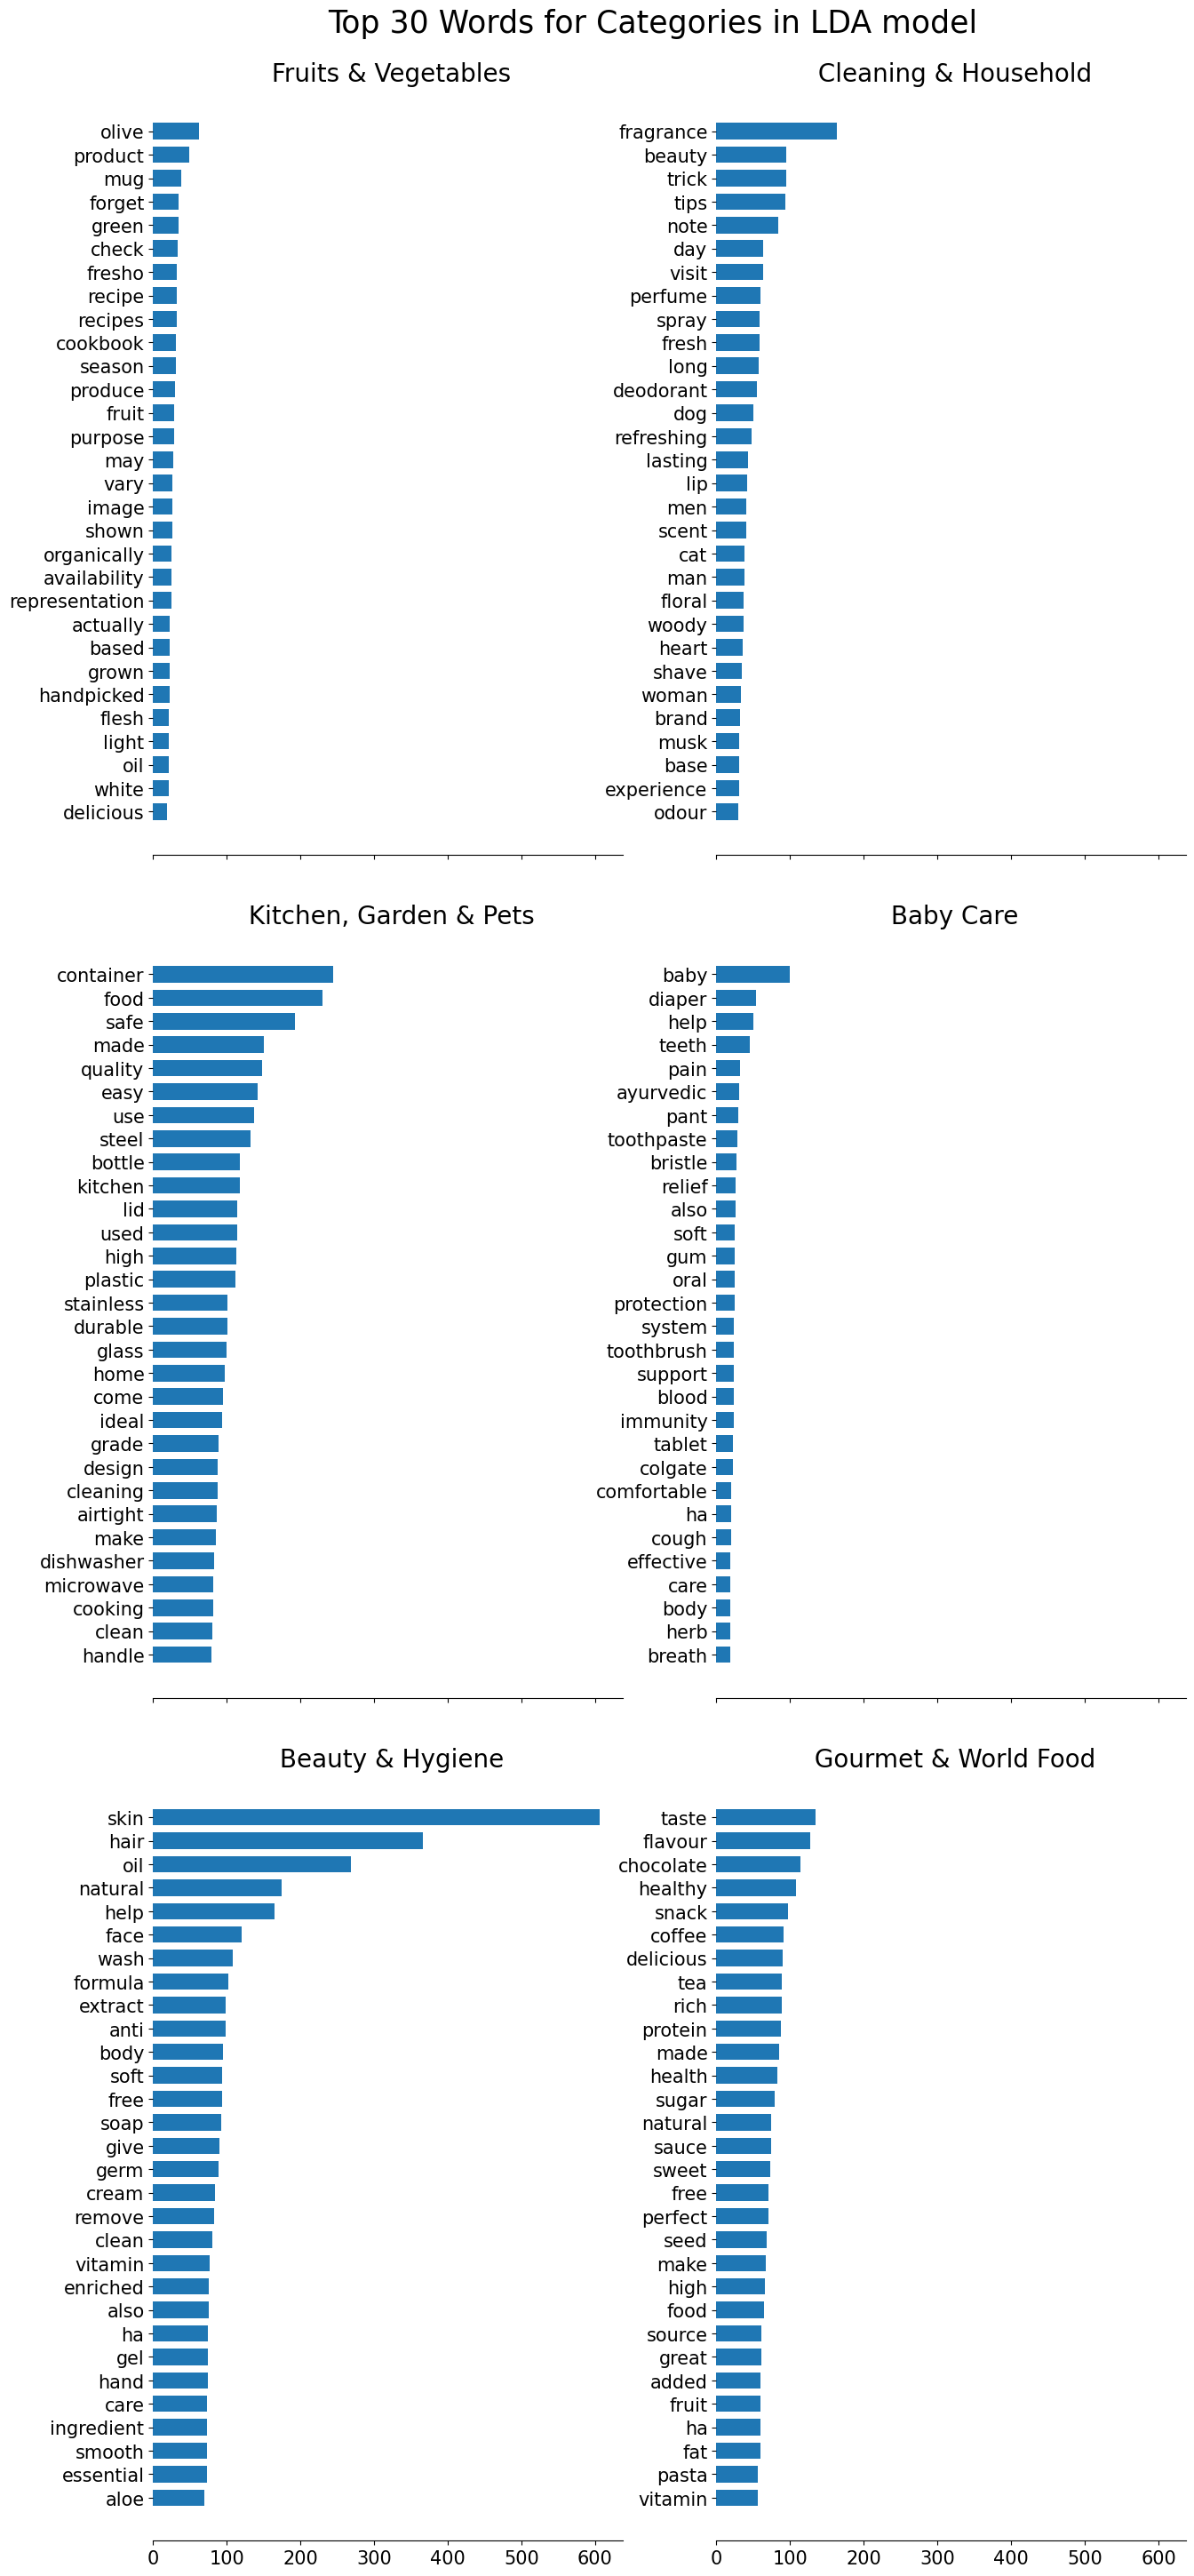

In [45]:
plot_top_words(lda_tfidf, tfidf.get_feature_names_out(), 30, "Top 30 Words for Categories in LDA model", best_map)

## Recommender System


Despite not getting good results with unsupervised learning in the sections above, unsupervised models are still quite useful in various applications. For example, we can use unsupervised models to build a recommender system to recommend products to the potential customers.

A recommender system can recommend products based on a variety of criteria. Given the data set we have, I think we can use the similarity of product descriptions to recommend products.

In [46]:
# Make a fresh copy of original data set
df_rec = df.copy()
df_rec['description'] = df_rec['description'].apply(lambda x: dataCleansing(x))
df_rec.drop(columns=['sale_price', 'market_price', 'type', 'brand'], inplace=True, axis=1)

In [47]:
df_rec.reset_index(drop=True, inplace=True)
df_rec

,product,category,sub_category,description
0,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,this product contains garlic oil that is known...
1,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,"each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,"a perfect gift for all occasions, be it your m..."
3,Cereal Flip Lid Container/Storage Jar - Assort...,Cleaning & Household,Bins & Bathroom Ware,multipurpose container with an attractive desi...
4,Creme Soft Soap - For Hands & Body,Beauty & Hygiene,Bath & Hand Wash,nivea creme soft soap give your skin the best ...
...,...,...,...,...
19517,Apple Cider Vinegar Shampoo,Beauty & Hygiene,Hair Care,"say no to dull, lifeless, dry and damaged hair..."
19518,"Wottagirl! Perfume Spray - Heaven, Classic",Beauty & Hygiene,Fragrances & Deos,layerr brings you wottagirl classic fragrant b...
19519,Rosemary,Gourmet & World Food,Cooking & Baking Needs,puramate rosemary is enough to transform a dis...
19520,Peri-Peri Sweet Potato Chips,Gourmet & World Food,"Snacks, Dry Fruits, Nuts",we have taken the richness of sweet potato (sh...


In [48]:
tfidf_rec = TfidfVectorizer(lowercase = True, stop_words = stpwrd)
X_rec = tfidf_rec.fit_transform(df_rec['description'])
sim_matrix = linear_kernel(X_rec)

Here we vectorize the corpus using a TF-IDF vectorizer. Then we compute the similarity matrix, which contains the pairwise cosine similarity for every pair of products. To recommend for a product, we sort the row of the similarity matrix for this product, and return the ones with the highest similarity scores.

The three attempts with the recommender below show decent results. In the first attempt, we want to recommend similar products to the `Germ - Removal Multipurpose Wipes`. We can see that the recommender returns a list of cleaning products or wipes.

In the second attempt, the product we use as input is some sort of sports supplement. What we got from the recommender are also sports supplement or nutrition products.

In the third attempt, we want to recommend similar products as `Kanakasavam`, which is some type of Indian herbal medicine for cough or asthma. The recommender returns either Indian herbal medicine or cold/asthma medication. 

Everything considered, I would say our recommender here performs like we expected. And there is still lots of great potential at improving this recommender. For example, we can build the recommender to consider customer preference and/or purchase history had we had the access to the data.

In [49]:
def recommend_similar_product(product_id=0, n_recommendation=20):
    # check if product id is in bound
    if product_id < 0 or product_id >= sim_matrix.shape[0]:
        print("Product ID {} out of range".format(product_id))
        return
    
    # list all the similarities with index
    cos_sim = list(enumerate(sim_matrix[product_id]))
    cos_sim.sort(key=lambda x:x[1], reverse=True)
    
    recommended_index = [cos_sim[i][0] for i in range(n_recommendation)]
    return df_rec.iloc[recommended_index]

In [50]:
pd.set_option('display.max_colwidth', 100)

In [51]:
recommend_similar_product(product_id=5, n_recommendation=15)

,product,category,sub_category,description
5,Germ - Removal Multipurpose Wipes,Cleaning & Household,All Purpose Cleaners,"stay protected from contamination with multipurpose germ removal wipe by nature protect, a quali..."
5713,Germ Removal Detergent,Cleaning & Household,Detergents & Dishwash,"maintaining hygiene at all time ha become more important than ever, and more and more people are..."
19026,Germ Kill Spray,Cleaning & Household,All Purpose Cleaners,provide yourself and your loved one effective protection from germ at every moment with the mult...
11985,Disinfectant Surface Cleaner,Cleaning & Household,All Purpose Cleaners,"maintaining hygiene at all time ha become more important than ever, and more and more people are..."
12478,Wet Wipes - Germ Protection On the Go,Beauty & Hygiene,Skin Care,"each day, when we step out of the house, for shopping groceries, commuting or while working out ..."
7468,Germ Protection Multipurpose Thick & Soft Wet Wipes with Fliptop Lid,Cleaning & Household,"Disposables, Garbage Bag",savlon germ protection wipe protect you from 99.99% germs* along with dust and impurities. these...
2002,Eco Multipurpose Sanitising Wipes - Fresh Lemon,Cleaning & Household,All Purpose Cleaners,"ajax eco multipurpose wipe for sparkling clean surfaces, make cleaning a breeze. feel proud usin..."
15161,Eco Multipurpose Sanitising Wipes - Lavender,Cleaning & Household,All Purpose Cleaners,"ajax eco multipurpose wipe for sparkling clean surfaces, make cleaning a breeze. feel proud usin..."
8081,Disinfectant Surface Cleaning Spray,Cleaning & Household,All Purpose Cleaners,keep your home’s surface hygienically clean with the nature protect disinfectant surface cleaner...
17322,"Anti Bacterial Household Surface - 40%Extra free, Imported",Cleaning & Household,All Purpose Cleaners,greenshield anti bacterial household surface wipe can be used a a convenient way to clean moreov...


In [52]:
recommend_similar_product(product_id=999, n_recommendation=15)

,product,category,sub_category,description
999,Recover Effervescent Tablets with Essential Amino Acids - Raspberry Flavour,Beauty & Hygiene,Health & Medicine,post-workout recovery of muscle is something which need to be one’s priority when it come to int...
7322,Activate Pre Workout Effervescent Tablets - Orange Flavour,Beauty & Hygiene,Health & Medicine,fast&up activate is a pre-workout sport nutrition drink which provides instant and enduring ener...
18853,"BCAA With Arginine, Glutamine & Muscle Activation Boosters - Lime & Lemon Flavour",Beauty & Hygiene,Health & Medicine,fast&up bcaa in lime & lemon is crafted with 5g bcaa consisting of an ideal 2:1:1 ratio of l-leu...
5299,"BCAA with Arginine, Glutamine & Muscle Activation Boosters - Green Apple Flavour",Beauty & Hygiene,Health & Medicine,amino acid play a vital role in muscle strength and are required by the body to maintain a highe...
5057,"Skin Fit - Pre-Workout High Performance Sunscreen, SPF 50",Beauty & Hygiene,Skin Care,the pond’s skin fit pre-workout high-performance sunscreen with spf pa+++ uva uvb help ensure th...
2227,Skin Fit - Post-Workout Cooldown Hydrating Gel,Beauty & Hygiene,Skin Care,use the pond’s skin fit post-workout cooldown hydrating gel moisturiser after a workout session ...
10219,Skin Fit - Post-Workout Instant Cooldown Wipes,Beauty & Hygiene,Skin Care,use the pond’s skin fit post-workout instant cooldown wipe for a quick and easy fix with gentle ...
18602,Intensive Pre-Workout Formula - 20 Servings,"Kitchen, Garden & Pets",Pet Food & Accessories,"power-packed with amino acids, vitamins, minerals, natural caffeine from coffee beans, with bota..."
6361,Pure & Raw L-Arginine - 50 Servings,"Kitchen, Garden & Pets",Pet Food & Accessories,nitric oxide is a powerful neurotransmitter that help blood vessel relax and also improves circu...
6428,Instantized BCAA Enriched With Electrolytes,"Kitchen, Garden & Pets",Pet Food & Accessories,"research proven 2:1:1 ratio of bcaa: btn instantized bcaa contains two part of leucine, one part..."


In [53]:
recommend_similar_product(product_id=12345, n_recommendation=15)

,product,category,sub_category,description
12345,Kanakasavam,Beauty & Hygiene,Health & Medicine,"kanakasavam is an ayurveda formulation, widely used in the treatment of respiratory disorders. i..."
18597,Dasamoolam Kwath,Beauty & Hygiene,Health & Medicine,dasamoolam kwath is a classical ayurveda formulation beneficial in respiratory disorders. it aid...
15145,Kokilakshakam Kwath,Beauty & Hygiene,Health & Medicine,kerala ayurveda kokilakshakam kwath is a classical herbal formulation beneficial in gout and oth...
17107,Agasthyarasayanam,Beauty & Hygiene,Health & Medicine,kerala ayurveda's agasthyarasayanam is an ayurvedic medicine that is known to help ease respirat...
15032,Sudarsanasavam,Beauty & Hygiene,Health & Medicine,"sudarsanasavam is an ayurvedic medicine that can help in the treatment of viral fever, chronic f..."
246,Dhanwantharam Kwath,Beauty & Hygiene,Health & Medicine,dhanwantharam kwath is an ayurveda formulation that help relieve vata disorder and postnatal dif...
4716,Patolakatukurohinyadi Kwath,Beauty & Hygiene,Health & Medicine,patolakatukurohinyadi kwath is a classical ayurveda decoction beneficial in skin disease with pi...
2659,"Vyagradhi - Decongestant, 500 mg",Beauty & Hygiene,Health & Medicine,"vyagradhi is a herbal combination, which ha a curative effect on the respiratory system. it can ..."
11010,Kasamrita Herbal Syrup - For Cough & Cold,Beauty & Hygiene,Health & Medicine,baidyanath kasamrit herbal cough syrup is a non-drowsy tonic which act a a herbal supplement for...
18077,Dasamoolarishtam,Beauty & Hygiene,Health & Medicine,dasamoolarishtam is a potent ayurvedic formulation beneficial in a wide variety of diseases. a n...


## Conclusion

In this project, we attempted to categorize the products based on the descriptions using unsupervised learning models. The results turned out to be underwhelming, as supervised models perform much better at this task.

Nonetheless, we proceeded to build a recommender system with unsupervised learning. The recommender system performed well to the expectations. All in all, unsupervised learning methods can be incredibly practical at the right types of applications.

## References

SJ. (2022). BigBasket Entire Product List (~28K datapoints) [Data set]. Kaggle. https://www.kaggle.com/datasets/surajjha101/bigbasket-entire-product-list-28k-datapoints


Kang, C. (2020, July 17). TF-IDF and similarity scores. Chan`s Jupyter. https://goodboychan.github.io/python/datacamp/natural_language_processing/2020/07/17/04-TF-IDF-and-similarity-scores.html#The-recommender-function 